In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
import sklearn
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import pickle

2023-03-10 23:55:17.729840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 23:55:18.340778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 23:55:18.340800: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 23:55:20.122749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# <span style="color:purple"> LEITURA DATASET </span>

In [2]:
columns = [i for i in range(0, 63)]
columns.extend(["classe", "signer"])
dataset = pd.read_csv('dataset.csv')
dataset.columns = columns
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,classe,signer
0,-0.015155,0.083723,-0.019764,0.016621,0.067022,-0.016464,0.037898,0.040288,-0.018105,0.048381,...,-0.013157,-0.029493,-0.019044,0.004893,-0.044368,-0.022143,0.026663,-0.034211,a,0.0
1,-0.017470,0.089129,-0.024697,0.017672,0.070180,-0.018930,0.037136,0.042391,-0.020137,0.047958,...,-0.013763,-0.033332,-0.020168,0.004791,-0.048958,-0.022997,0.025612,-0.040157,a,0.0
2,-0.018608,0.088464,-0.034686,0.017341,0.069314,-0.027479,0.036115,0.041589,-0.026058,0.046782,...,-0.015631,-0.034420,-0.021920,0.002710,-0.050564,-0.024800,0.022225,-0.041706,a,0.0
3,-0.018881,0.089806,-0.033932,0.017604,0.069527,-0.027086,0.036691,0.042036,-0.025525,0.047545,...,-0.016675,-0.034124,-0.021750,0.000277,-0.050739,-0.023401,0.019764,-0.042837,a,0.0
4,-0.018110,0.088998,-0.032207,0.016747,0.068922,-0.024993,0.036877,0.042021,-0.023326,0.047667,...,-0.015065,-0.034571,-0.020478,0.001885,-0.050963,-0.022766,0.021520,-0.041488,a,0.0


In [4]:
len(dataset.index)

15744

In [3]:
signers_train = [0, 1, 2, 3, 4, 5, 6, 7, 8]
signers_test = [1, 2, 4]

In [4]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'y']

In [5]:
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [6]:
dataset_train = dataset.loc[dataset['signer'].isin(signers_train)]

In [7]:
feats = [i for i in range(0, 63)]

X_train = np.array(dataset_train[feats])
Y_train = np.array(le.transform(dataset_train['classe']))

#X_train = preprocessing.normalize(X_train)

In [123]:
dataset_test = dataset.loc[dataset['signer'].isin(signers_test)]

In [124]:
X_test = np.array(dataset_test[feats])
Y_test = np.array(le.transform(dataset_test['classe']))

#X_test = preprocessing.normalize(X_test)

# <span style="color:purple"> ANÁLISE DO DATASET</span>

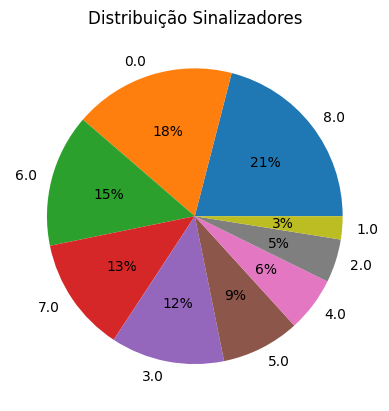

In [125]:
signer_data = dataset['signer'].value_counts()
plt.title('Distribuição Sinalizadores')
_ = plt.pie(signer_data, labels=signer_data.index, autopct='%.0f%%')

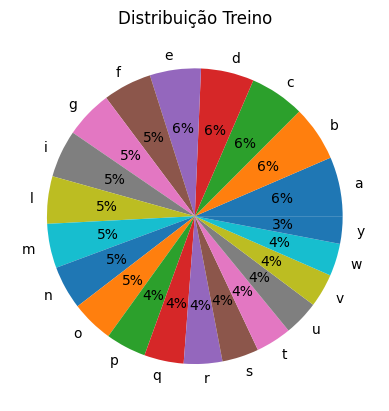

In [126]:
data = dataset_train['classe'].value_counts()
plt.title('Distribuição Treino')
_ = plt.pie(data, labels=classes, autopct='%.0f%%')

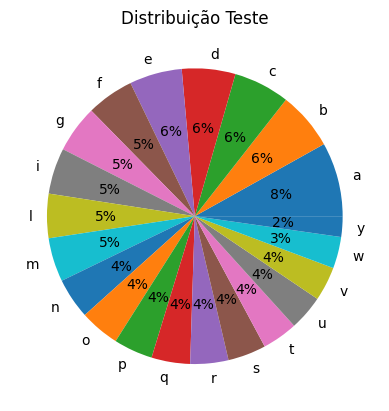

In [127]:
data = dataset_test['classe'].value_counts()
plt.title('Distribuição Teste')
_ = plt.pie(data, labels=classes, autopct='%.0f%%')

In [128]:
X_train.shape, X_test.shape

((13658, 63), (2086, 63))

# <span style="color:purple"> SVM </span>

In [129]:
model = svm.SVC(decision_function_shape='ovo')

In [130]:
model.fit(X_train, Y_train)

SVC(decision_function_shape='ovo')

In [131]:
pred = model.predict(X_test)

In [132]:
print(classification_report(Y_test, pred, target_names=classes))

              precision    recall  f1-score   support

           a       0.99      0.99      0.99       132
           b       0.99      1.00      0.99        72
           c       0.93      1.00      0.96       169
           d       0.99      0.89      0.94       120
           e       0.99      1.00      1.00       100
           f       0.68      0.63      0.66       122
           g       1.00      0.96      0.98       108
           i       1.00      0.66      0.79        88
           l       0.96      1.00      0.98       108
           m       0.95      0.95      0.95        87
           n       0.63      0.61      0.62       101
           o       1.00      0.99      0.99        91
           p       0.99      1.00      1.00       105
           q       0.52      0.54      0.53        81
           r       0.74      0.96      0.84        80
           s       0.99      0.99      0.99        78
           t       0.55      0.60      0.57        89
           u       1.00    

<AxesSubplot:>

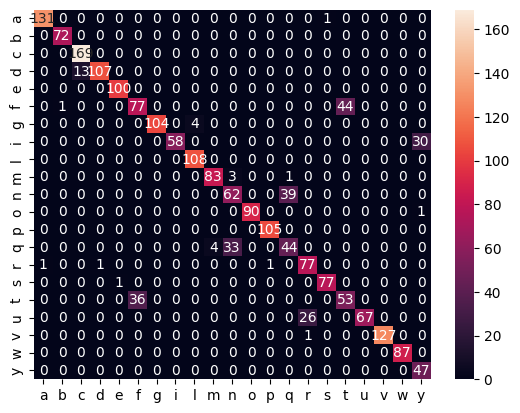

In [133]:
cm = confusion_matrix(Y_test, pred)

df_cm = pd.DataFrame(np.array(cm), index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt=".0f")

# <span style="color:purple"> OPTUNA </span>

In [8]:
def objective(trial):
    
    gamma = trial.suggest_float('gamma', 0.0001, 10)
    c = trial.suggest_float('c', 0.1, 100)
    
    clf = svm.SVC(decision_function_shape='ovr', C=c, gamma=gamma)
    
    return sklearn.model_selection.cross_val_score(
        clf, X_train, Y_train, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-10 23:55:40,646] A new study created in memory with name: no-name-17eb0a4c-9530-4fd2-9010-116bc1ea2da8
[I 2023-03-10 23:55:43,549] Trial 0 finished with value: 0.9174288617886178 and parameters: {'gamma': 6.653555257097357, 'c': 34.599940229243316}. Best is trial 0 with value: 0.9174288617886178.
[I 2023-03-10 23:55:45,230] Trial 1 finished with value: 0.9153328252032521 and parameters: {'gamma': 3.7450095309888733, 'c': 23.432056287280314}. Best is trial 0 with value: 0.9174288617886178.
[I 2023-03-10 23:55:46,453] Trial 2 finished with value: 0.9222560975609756 and parameters: {'gamma': 7.9229403846201745, 'c': 66.199708350699}. Best is trial 2 with value: 0.9222560975609756.
[I 2023-03-10 23:55:47,603] Trial 3 finished with value: 0.9157139227642276 and parameters: {'gamma': 7.822791085575385, 'c': 11.929398146707534}. Best is trial 2 with value: 0.9222560975609756.
[I 2023-03-10 23:55:48,477] Trial 4 finished with value: 0.9227642276422765 and parameters: {'gamma': 6.924

Accuracy: 0.9235264227642276
Best hyperparameters: {'gamma': 5.6003141996977615, 'c': 75.58282041689712}


In [9]:
final_model = svm.SVC(decision_function_shape='ovr', gamma=5.6003141996977615, C=75.58282041689712, probability=True)

In [10]:
final_model.fit(X_train, Y_train)

SVC(C=75.58282041689712, gamma=5.6003141996977615, probability=True)

In [14]:
final_model.predict_proba(x)

array([[9.63753315e-05, 1.11718125e-05, 7.98569584e-05, 5.89661710e-05,
        3.48396298e-05, 2.82067421e-05, 6.96863823e-05, 4.21010898e-05,
        4.64403530e-05, 5.37764739e-05, 7.39773458e-05, 9.41802227e-05,
        8.62811340e-05, 6.98547657e-05, 1.45797424e-05, 1.23106250e-04,
        2.80544001e-05, 4.01177884e-05, 4.27979782e-05, 9.98822666e-01,
        8.29638639e-05]])

CONVERT TO ONNX

In [17]:
initial_type = [ 
    ( 'input_landmarks' , FloatTensorType( [None,63] ) ) 
]

converted_model = convert_sklearn(final_model, initial_types=initial_type)

with open( "alphabet_model.onnx", "wb" ) as f:
        f.write( converted_model.SerializeToString() )

In [12]:
import onnxruntime as rt

In [13]:
x = np.array([X_train[10323]])
x.shape

(1, 63)

In [16]:
sess = rt.InferenceSession("alphabet_model.onnx")
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x.astype(np.float32)})
pred_onx[1]

[{0: 9.63747879723087e-05,
  1: 1.1172056474606507e-05,
  2: 7.986390846781433e-05,
  3: 5.8974590501748025e-05,
  4: 3.482964530121535e-05,
  5: 2.820617737597786e-05,
  6: 6.968307570787147e-05,
  7: 4.210503539070487e-05,
  8: 4.644275759346783e-05,
  9: 5.377190245781094e-05,
  10: 7.397763693006709e-05,
  11: 9.417841647518799e-05,
  12: 8.628205978311598e-05,
  13: 6.985724758123979e-05,
  14: 1.4576001376553904e-05,
  15: 0.00012310642341617495,
  16: 2.805218355206307e-05,
  17: 4.009984331787564e-05,
  18: 4.2822983232326806e-05,
  19: 0.9988223910331726,
  20: 8.296639862237498e-05}]